# Collaborative Filtering for Movie Recommendations

**Author:** [Siddhartha Banerjee](https://twitter.com/sidd2006)<br>
**Date created:** 2020/05/24<br>
**Last modified:** 2020/05/24<br>
**Description:** Recommending movies using a model trained on Movielens dataset.

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)


In [5]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


## First, load the data and apply preprocessing


In [6]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


991232/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [7]:
print(ratings_file)

/root/.keras/datasets/ml-latest-small/ratings.csv


First, need to perform some preprocessing to encode users and movies as integer indices.


In [8]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [11]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [12]:
df.tail()

,userId,movieId,rating,timestamp,user,movie
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392
100835,610,170875,3.0,1493846415,609,2873


## Prepare training and validation data


In [13]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [15]:
print(x_train.shape)  
print(x_val.shape)  
print(y_train.shape)  
print(y_val.shape)  

(90752, 2)
(10084, 2)
(90752,)
(10084,)


In [17]:
x_train

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 589, 5054],
       [ 135,  636],
       [ 274, 3747]])

In [18]:
y_train

array([0.88888889, 0.55555556, 0.55555556, ..., 0.55555556, 1.        ,
       0.11111111])

## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [19]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Train the model based on the data split


In [26]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=2,
    epochs=30,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/30
 3873/45376 [=>............................] - ETA: 2:45 - loss: 0.5890

KeyboardInterrupt: ignored

## Plot training and validation loss


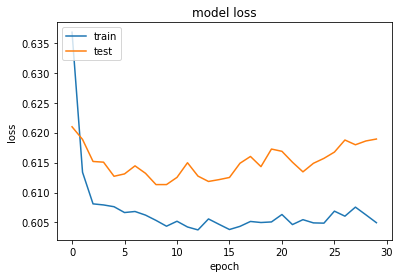

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


## Show top 10 movie recommendations to a user


In [25]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
print("userId: ", user_id)
print()
movies_watched_by_user = df[df.userId == user_id] # 사용자가 본 영화만 선택
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"] # 사용자가 안본 데이터셋

movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

print(movies_not_watched[:5]) # 안본 데이터중 5개 출력

user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

print()
print("user_mvoie array: ", user_movie_array)

ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
print()
print(top_ratings_indices[:5])
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


userId:  414

[[5804], [482], [5017], [1399], [488]]

user_mvoie array:  [[ 413 5804]
 [ 413  482]
 [ 413 5017]
 ...
 [ 413 3870]
 [ 413 2989]
 [ 413 7869]]

[3265 1813 4471 1802 3634]
Showing recommendations for user: 414
Movies with high ratings from user
--------------------------------
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Some Like It Hot (1959) : Comedy|Crime
Wallace & Gromit: The Wrong Trousers (1993) : Animation|Children|Comedy|Crime
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Rushmore (1998) : Comedy|Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975) : Comedy|Drama
Yojimbo (1961) : Action|Adventure
Double Indemnity (1944) : Crime|Drama|Film-Noir
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Adam's Rib (1949) : Comedy|Romance
Neon Genesis Evangelion